Preparation

In [ ]:
! rm -rf DPiP_project # delete in case it was cloned before
! git clone https://github.com/hengoe/DPiP_project.git 
from DPiP_project.code import *

# create test folder
!mkdir test_folder
!mkdir test_folder/data
!mkdir test_folder/models

## Introduction

For this project, we wanted to create functionality to 
1. retrieve tweets from twitter containing a specific topic_key and
2. analyze these tweets regarding their sentiment.

For data retrieval we introduced the DataRetriever class providing functionality to retrieve training data as well as realistic data from twitter. Both can be saved as csv for later.
For the analysis part, we introduced three classes, namely Models, ModelTrainer and ModelApplier. Models is the parent class of the other both and contains common utilities. ModelTrainer can be used to train a classifier on the training data and save the model for later usage. ModelApplier can be used to load a pretrained model and classify new realistic data. It allows to get an impression of the overall sentiment represented in tweets on the topic_key. Thus, a model can once be trained and later on loaded multiple times to classify new tweets regarding the same topic key. For example, a company could use this to get Twitter's current sentiment towards the company and track results over time. 

Useful graphics are provided in order to evaluate the goodness of the classifier and interpret results of classifying new data.

## Data Retrieval

The first step in the project -- data retrieving -- starts with initializing access token and secret, consumer key and secret, and initializing DataRetriver class (used to retrieve data for the training set and realistic data). 

In [ ]:
# initialize DataRetriever
access_token = ''
access_token_secret = ''

consumer_key = ''
consumer_secret = ''

retr = DataRetriever()

### Getting Training Data for the Classifier

The model that later performs the sentiment analysis must be trained beforehand. For this, data is retrieved based on the topic_key (here: "McDonald's") and two keys representing the positive and negative sentiment of the tweets. pos_key and neg_key are by default set to ":)" and ":(". One could e.g. replace them by "happy" and "sad" or "good" and "bad". 

Retrieving training data that likely has positive/negative sentiment is important to train the classifier. Specifically, the number of tweets with positive and negative sentiment should be roughly the same. Therefore, the function will automatically retrieve approximately the same amount of 
1. tweets that include the topic_key and pos_key and 
2. tweets that include the topic_key and neg_key. 

After retrieval all keywords are deleted from the tweets. If the positive and negative keywords remained in the tweets the classifier would fastly recognize them. This would lead to bad out-of-sample performance, which is the main target of the project - to classify new tweets that do not necessarily contain our positive/negative keywords.

The data can be saved for further analysis (in pandas dataframe). It includes time, twitter id, text and label (1 -- positive, 0 -- negative). All tweets are in English language so that the classifier can be trained successfully and the pretrained wort embedding matches the words used in the tweets.

In [ ]:
# get training data
training_data = retr.get_training_data(access_token=f"{access_token}", access_token_secret=f"{access_token_secret}",
                              consumer_key=f"{consumer_key}", consumer_secret=f"{consumer_secret}", 
                              topic_key="McDonald's", N=5000, save_to_csv=True, file_path="/content/test_folder/data/")


The retrieved data can be accessed via the training_data field of the DataRetriever class. Since duplicates are removed it may happen that there are a few less tweets than initially wanted although we introduced a buffer.

In [ ]:
retr.training_data.head()

,time,id,text,label
0,2021-09-02 12:04:37,1433400466931597317,Justin gonna do baaaad things to Chandler man ...,0
1,2021-09-02 12:04:37,1433400466700787718,@ddacoups omg aya i really hope youre okay p...,0
2,2021-09-02 12:04:37,1433400466214473729,"@yngjluvr watch if you want, don't if you can'...",0
3,2021-09-02 12:04:36,1433400464515739649,@icy_h9t He solo'd me and made me put on this...,0
4,2021-09-02 12:04:36,1433400463471247366,@taeminsdeaIer Bae what is happening? (,0


### Getting realistic data for information gain

For the company - in our example McDonald's - it is interesting to know the current sentiment that twitter users have about them. Thus, it makes sense to also be able to retrieve realistic data representing all tweets that are posted regarding the topic_key, regardless of positive or negative sentiment. Just like this, a realistic overview on the overall sentiment towards the topic_key can be obtained.

This is why get_realistic_data only retrieves tweets that have topic_key in the text. Again, the data can be saved to csv for later usage.

In [ ]:
# get realistic data
real_data = retr.get_realistic_data(access_token=access_token, access_token_secret=access_token_secret,
                              consumer_key=consumer_key, consumer_secret=consumer_secret,
                              topic_key="McDonald's", N=1000, save_to_csv=True, file_path="/content/test_folder/data/")

Rate limit reached. Sleeping for: 233


The realistic data can be accessed as follows. As one can see, there is no label indicating the sentiment of the tweet - because we do not know it.

In [ ]:
retr.realistic_data.head()

,time,id,text
0,2021-09-02 12:44:39,1433410544040435717,RT @crackcobain__: McDonald’s breakfast deserv...
1,2021-09-02 12:44:36,1433410528894988289,@plankdaddy @Whiteboyramen1 @sherman21 @Robill...
2,2021-09-02 12:44:21,1433410466404053003,RT @CieThePisces: @YoungJazzyHo @TMZ Someone c...
3,2021-09-02 12:44:19,1433410457633701892,McDonald’s has an iced pumpkin spice coffee an...
4,2021-09-02 12:44:15,1433410440009326594,RT @JJHTweets: This hasn't aged well.... @Nige...


## Let's get to training and applying the classifier

### Model Training

Initialize that ModelTrainer with the data you want to analyze and feed it with the column names for the column with the tweets and the one with the target labels.

In [ ]:
glove_path = "/content/DPiP_project/glove.6B.50d.txt" # pretrained word embedding

# create model class instance
mtrainer = ModelTrainer(raw_data=retr.training_data, model_folder_path="/content/test_folder/models/", 
                        colname_tweets="text", colname_label="label")


#### Explanation of the function train_model_on_data
Train the model. With optional arguments it is possible to set different model specifications and find the one that results in the best model. This includes lstm sizes, dropout rates, epochs of training and batch size.
#### Overfitting graph
This graph allows to judge the training of the model. Specifically, overfitting, which is a huge problem of deep neural networks, can be detected and the training specifications can be adjusted for the next round of training. Overfitting is indicated by a better accuracy (left graph) on the training than on the testing data or by an increasing loss in the right graph. 
If overfitting occurs, possible steps to take would be e.g. to decrease the lstm size, increase the dropout rate or train for a smaller amount of epochs.

Shape of ... Training Data:  (3088, 6)  ... Final Evaluation Data:  (344, 6)
There were 5573 unique words found.
Epoch 1/7
39/39 [==============================] - 8s 81ms/step - loss: 0.6608 - binary_accuracy: 0.6036 - true_negatives_5: 603.0000 - true_positives_5: 888.0000 - false_negatives_5: 412.0000 - false_positives_5: 567.0000 - val_loss: 0.6206 - val_binary_accuracy: 0.6634 - val_true_negatives_5: 213.0000 - val_true_positives_5: 197.0000 - val_false_negatives_5: 141.0000 - val_false_positives_5: 67.0000
Epoch 2/7
39/39 [==============================] - 2s 61ms/step - loss: 0.6150 - binary_accuracy: 0.6696 - true_negatives_5: 862.0000 - true_positives_5: 792.0000 - false_negatives_5: 508.0000 - false_positives_5: 308.0000 - val_loss: 0.5960 - val_binary_accuracy: 0.6974 - val_true_negatives_5: 241.0000 - val_true_positives_5: 190.0000 - val_false_negatives_5: 148.0000 - val_false_positives_5: 39.0000
Epoch 3/7
39/39 [==============================] - 2s 46ms/step - loss: 0.588

INFO:tensorflow:Assets written to: /content/test_folder/models//model/assets


INFO:tensorflow:Assets written to: /content/test_folder/models//model/assets


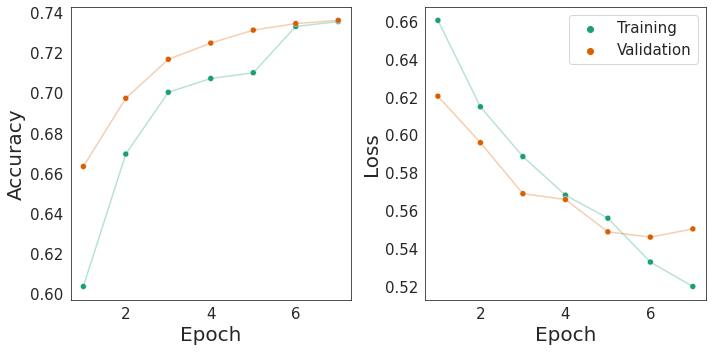

In [ ]:
mtrainer.train_model_on_data(glove_path=glove_path, overfitting_plot=True, save_model=True, lstm_size=64, 
                             dropout_rate=0.5, n_epochs=7, batch_size=64)    

#### Explanation of the function evaluate_out_of_sample and the returned dataframe
For classifier models it is very important to evaluate their performance out-of-sample. The model is trained on 90% of the data and 10% are automatically held back and never shown to the classifier. With evaluate_out_of_sample() the model's performance on these 10% can be evaluated. It returns the predictions dataframe containing the original tweets with the assigned label as well as the probability for the positive label. With this probability it can be seen how "sure" the model is about the prediction. A value close to 0 shows a quite negative sentiment, a values close to 1 a positive. Values in the middle suggest that the classifier ist not quite certain about the tweet's sentiment.
### Confusion Matrix
With the aid of the confusion matrix, the share of correctly and incorrectly classified tweets can be seen clearly.
### Distribution of predicted probabilities for positive sentiment
The other graph displaying the distribution of predicted probabilities allows to draw conclusions on the overall sentiment of the predicted tweets. A right-skewed distribution shows a rather positive overall sentiment. A rather even distribution would suggest that there is no clear tendency in the tweets.

11/11 [==============================] - 0s 10ms/step - loss: 0.5603 - binary_accuracy: 0.7355 - true_negatives_5: 114.0000 - true_positives_5: 139.0000 - false_negatives_5: 46.0000 - false_positives_5: 45.0000


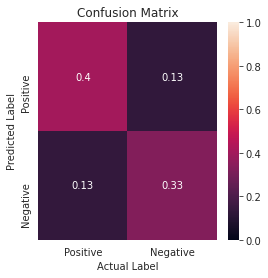

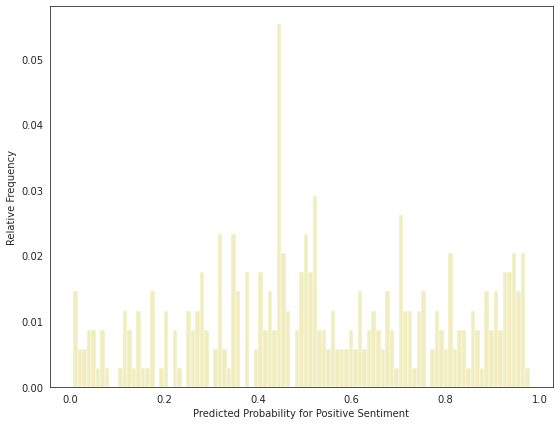

In [ ]:
mtrainer.evaluate_out_of_sample(return_predictions=True, confusion_matrix=True, predictions_histogram=True)

### Application of the trained model

Now, it's time to apply the trained model to realistic data and have a look at the classification it produces.

29/29 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0000e+00 - true_negatives_5: 0.0000e+00 - true_positives_5: 0.0000e+00 - false_negatives_5: 0.0000e+00 - false_positives_5: 0.0000e+00


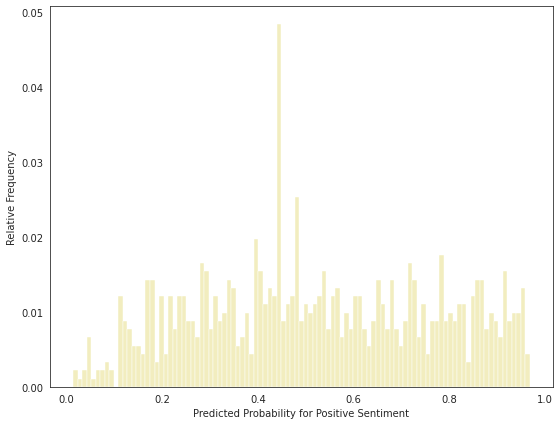

In [ ]:
mapplier = ModelApplier(raw_data=retr.realistic_data, model_folder_path="/content/test_folder/models/", colname_tweets="text")

mapplier.predict_new_data()

Under predicted_df one can find the original tweets along with their predicted probability for a positive sentiment. Thus, for probabilities <0.5 we assign a negative label and for >0.5 a positive label. 

In above graph one can detect tendencies, e.g. when the distribution is rather right-scewed the overall sentiment towards the topic_key can be assumend to be rather positive. 

In [ ]:
mapplier.predicted_df.head()


,text,predicted label,probability for positive label
0,RT @crackcobain__: McDonald’s breakfast deserv...,1,0.77507
1,@plankdaddy @Whiteboyramen1 @sherman21 @Robill...,1,0.87189
2,RT @CieThePisces: @YoungJazzyHo @TMZ Someone c...,1,0.60780
3,McDonald’s has an iced pumpkin spice coffee an...,1,0.90231
4,RT @JJHTweets: This hasn't aged well.... @Nige...,0,0.44425
